In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline  
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, roc_auc_score, precision_recall_curve,
    average_precision_score, f1_score, accuracy_score
)
from sklearn.model_selection import StratifiedKFold
from functions_ver2 import data_pipeline as data_pipeline_v2
from functions import data_pipeline_v1


### Resample First

In [ ]:
X_train_std, y_train, X_train_smote_std, y_train_smote, X_train_smotetomek_std, y_train_smotetomek, X_train_cc_std, y_train_cc, X_test_std, y_test = data_pipeline_v2('onehot')

Loading data
Splitting data
Total unique accounts: 45985. Starting to find cutoff point
Cutoff month where CDF reaches 80%: -10

=== Split based on CDF 80% cutoff ===
Cutoff month: -10 (10 months ago)
Old accounts (≤ month -10): 37,210 (80.9%)
New accounts (> month -10): 8,775 (19.1%)
Ratio (old/new): 4.2405
Splitting raw credit records
Cleaning old accounts credit records - [Length: 996586]


/workspaces/CS3244_ML_Project/functions_ver2.py:243: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df = df.groupby(['id', 'origination_month']).apply(lambda x: pd.Series({


Cleaning new accounts credit records - [Length: 51989]


/workspaces/CS3244_ML_Project/functions_ver2.py:243: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df = df.groupby(['id', 'origination_month']).apply(lambda x: pd.Series({
/workspaces/CS3244_ML_Project/functions_ver2.py:171: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dropped=df_sorted.groupby('id', group_keys=False).apply(keep_row)
/workspaces/CS3244_ML_Project/functions_ver2.py:171: FutureWarning: DataFr

Cleaning credit data completed
Splitting application dataset
Cleaning old accounts application records - [Length: (29264, 18)]
Cleaning new accounts appplication records, - [Length: (7193, 18)]
Encoding
Encoders: {'name_income_type': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'name_education_type': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'name_family_status': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'name_housing_type': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'occupation_type': OneHotEncoder(handle_unknown='ignore', sparse_output=False)}
Encoding type: onehot
Merging data
Engineering target variable to label data
Completed old accounts labelling
Completed new accounts labelling
Old accounts: (37210, 3)
New accounts: (8775, 3)
Old threshold: 0.20195195195195192
New threshold: 0.5786182336182336
Merging cleaned application and credit records
Train shape: (29264, 63)
Test shape: (7193, 63)
<class 'pandas.core.

### Resample In Model Pipeline

In [5]:
X_train_std, y_train, X_test_std, y_test = data_pipeline_v1('onehot')

Loading data
Splitting data
Total unique accounts: 45985. Starting to find cutoff point
Cutoff month where CDF reaches 80%: -10

=== Split based on CDF 80% cutoff ===
Cutoff month: -10 (10 months ago)
Old accounts (≤ month -10): 37,210 (80.9%)
New accounts (> month -10): 8,775 (19.1%)
Ratio (old/new): 4.2405
Splitting raw credit records
Cleaning old accounts credit records - [Length: 996586]


/workspaces/CS3244_ML_Project/functions.py:235: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df = df.groupby(['id', 'origination_month']).apply(lambda x: pd.Series({


Cleaning new accounts credit records - [Length: 51989]


/workspaces/CS3244_ML_Project/functions.py:235: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df = df.groupby(['id', 'origination_month']).apply(lambda x: pd.Series({
/workspaces/CS3244_ML_Project/functions.py:161: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dropped=df_sorted.groupby('id', group_keys=False).apply(keep_row)
/workspaces/CS3244_ML_Project/functions.py:161: FutureWarning: DataFrameGroupBy.appl

Cleaning credit data completed
Splitting application dataset
Cleaning old accounts application records - [Length: (29264, 18)]
Cleaning new accounts appplication records, - [Length: (7193, 18)]
Encoding
Encoders: {'name_income_type': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'name_education_type': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'name_family_status': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'name_housing_type': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'occupation_type': OneHotEncoder(handle_unknown='ignore', sparse_output=False)}
Encoding type: onehot
Merging data
Engineering target variable to label data
Completed old accounts labelling
Completed new accounts labelling
Old accounts: (37210, 3)
New accounts: (8775, 3)
Old threshold: 0.20207707707707706
New threshold: 0.5786182336182336
Merging cleaned application and credit records
Train shape: (29264, 63)
Test shape: (7193, 63)
<class 'pandas.core.

In [ ]:
def get_n_components(X_train, method="default"):
    pca = PCA()
    pca.fit(X_train)
    explained_var_ratio = pca.explained_variance_ratio_

    if method == "avg":
        avg_var = 1 / len(explained_var_ratio)
        optimal_components = np.sum(explained_var_ratio > avg_var)

    elif method == "elbow":
        diffs = np.diff(explained_var_ratio)
        elbow_idx = np.argmax(diffs * -1) + 1 
        optimal_components = elbow_idx

    elif method == "cumulative":
        cum_var = np.cumsum(explained_var_ratio)
        optimal_components = np.argmax(cum_var >= 0.95) + 1

    else:
        optimal_components = None

    return optimal_components

def build_knn_pipeline(pca_components=None, pca_method='default', use_smote=False, random_state=42):
    
    steps = []
    
    if use_smote:
        steps.append(('smote', SMOTE(random_state=random_state)))
    
    # Add PCA
    if pca_method == 'default' or pca_components is None:
        steps.append(('pca', PCA(whiten=True, random_state=random_state)))
    else:
        steps.append(('pca', PCA(n_components=pca_components, whiten=True, random_state=random_state)))
    
    steps.append(('knn', KNeighborsClassifier()))
    
    pipeline_cls = ImbPipeline if use_smote else Pipeline
    pipeline = pipeline_cls(steps)
    
    return pipeline

def tune_knn_pipeline(pipeline, X_train, y_train, param_grid, cv=3, scoring='f1', n_jobs=-1):
    grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=n_jobs)
    grid.fit(X_train, y_train)
    return grid.best_estimator_, grid.best_params_

def evaluate_and_plot(best_model, X_test, y_test, method_name='best'):
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:,1]

    results = {
        'test_accuracy': accuracy_score(y_test, y_pred),
        'test_f1': f1_score(y_test, y_pred),
        'test_roc_auc': roc_auc_score(y_test, y_proba),
        'test_ap': average_precision_score(y_test, y_proba),
        'classification_report': classification_report(y_test, y_pred, digits=3),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"ROC-AUC={results['test_roc_auc']:.3f}")
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({method_name})")
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label=f"AP={results['test_ap']:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve ({method_name})")
    plt.legend()
    plt.show()

    # Confusion Matrix
    sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix ({method_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print(results['classification_report'])
    
    return results


def model_pipeline_knn_pca(
    X_train, y_train, X_test=None, y_test=None,
    n_splits=5, random_state=42,
    pca_method='default', use_smote=False
):
    
    # Hyperparameter grid for KNN
    knn_param_grid = {
        'knn__n_neighbors': [3, 5, 7, 9, 11],
        'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean', 'minkowski', 'manhattan']
    }
    
    print(f"Starting PCA+KNN pipeline using '{pca_method}' method for n_components...\n")
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    fold_models, acc_scores, f1_scores, roc_scores, ap_scores = [], [], [], [], []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        components = get_n_components(X_tr, method=pca_method)
        pipeline = build_knn_pipeline(
            pca_components=components,
            pca_method=pca_method,
            use_smote=use_smote,
            random_state=random_state
        )
        best_pipeline, best_params = tune_knn_pipeline(pipeline, X_tr, y_tr, knn_param_grid, cv=3)
        
        y_pred = best_pipeline.predict(X_val)
        y_proba = best_pipeline.predict_proba(X_val)[:,1]
        
        acc_scores.append(accuracy_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred))
        roc_scores.append(roc_auc_score(y_val, y_proba))
        ap_scores.append(average_precision_score(y_val, y_proba))
        fold_models.append(best_pipeline)
        
        print(f"Fold {fold}: n_components={components}, Best Params={best_params}, "
              f"Acc={acc_scores[-1]:.3f}, F1={f1_scores[-1]:.3f}, "
              f"ROC-AUC={roc_scores[-1]:.3f}, AP={ap_scores[-1]:.3f}")
    
    best_fold_idx = int(np.argmax([
        roc_auc_score(y_train.iloc[val_idx], m.predict_proba(X_train.iloc[val_idx])[:,1])
        for m, (_, val_idx) in zip(fold_models, skf.split(X_train, y_train))
    ]))
    best_model = fold_models[best_fold_idx]
    
    print(f"\nBest fold selected: Fold {best_fold_idx+1} (ROC-AUC={roc_scores[best_fold_idx]:.3f})\n")

    results = {
        'cv_accuracy': np.mean(acc_scores),
        'cv_f1': np.mean(f1_scores),
        'cv_roc_auc': np.mean(roc_scores),
        'cv_ap': np.mean(ap_scores),
        'n_components': components,
        'best_fold_idx': best_fold_idx
    }
    
    if X_test is not None and y_test is not None:
        test_results = evaluate_and_plot(best_model, X_test, y_test, method_name=pca_method)
        results.update({f'test_{k}': v for k,v in test_results.items()})
    
    return results, best_model


In [ ]:
# def model_pipeline_knn_pca(
    X_train, y_train, X_test=None, y_test=None,
    n_splits=5, random_state=42
):
    
   
    knn_param_grid = {
        'knn__n_neighbors': [3, 5, 7, 9, 11],
        'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean', 'minkowski', 'manhattan']
    }
    
    print(f"Starting PCA+KNN pipeline with Stratified {n_splits}-Fold CV and hyperparameter tuning...\n")
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    method_metrics = {}

    for met in methods:
        fold_models, acc_scores, f1_scores, roc_scores, ap_scores = [], [], [], [], []
        print(f"--- PCA Method: {met} ---")
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Determine PCA components using custom function
            components = get_n_components(X_tr, method=met)
            if met == "default" or components is None:
                pca = PCA(whiten=True, random_state=random_state)
            else:
                pca = PCA(n_components=components, whiten=True, random_state=random_state)
            
            # Base pipeline
            pipeline = Pipeline([
                (f'pca ({met})', pca),
                ('knn', KNeighborsClassifier())
            ])
            
            # Hyperparameter tuning for KNN
            grid = GridSearchCV(
                pipeline,
                param_grid=knn_param_grid,
                scoring='f1',
                cv=3,
                n_jobs=-1
            )
            grid.fit(X_tr, y_tr)
            best_pipeline = grid.best_estimator_
            
            # Predict
            y_pred = best_pipeline.predict(X_val)
            y_proba = best_pipeline.predict_proba(X_val)[:,1]
            
            # Metrics
            acc_scores.append(accuracy_score(y_val, y_pred))
            f1_scores.append(f1_score(y_val, y_pred))
            roc_scores.append(roc_auc_score(y_val, y_proba))
            ap_scores.append(average_precision_score(y_val, y_proba))
            fold_models.append(best_pipeline)
            
            print(f"Fold {fold}: n_components={components}, Best Params={grid.best_params_}, "
                  f"Acc={acc_scores[-1]:.3f}, F1={f1_scores[-1]:.3f}, "
                  f"ROC-AUC={roc_scores[-1]:.3f}, AP={ap_scores[-1]:.3f}")
        
        
        method_metrics[met] = {
            'fold_models': fold_models,
            'cv_accuracy': np.mean(acc_scores),
            'cv_f1': np.mean(f1_scores),
            'cv_roc_auc': np.mean(roc_scores),
            'cv_ap': np.mean(ap_scores),
            'n_components': components
        }
        print(f"{met} → CV Mean Acc={np.mean(acc_scores):.3f}, F1={np.mean(f1_scores):.3f}, "
              f"ROC-AUC={np.mean(roc_scores):.3f}, AP={np.mean(ap_scores):.3f}\n")
    
    
    best_method = max(method_metrics.items(), key=lambda x: x[1]['cv_f1'])[0]
    best_fold_idx = int(np.argmax([roc_auc_score(y_train.iloc[val_idx], m.predict_proba(X_train.iloc[val_idx])[:,1])
                                   for m in method_metrics[best_method]['fold_models']]))
    best_model = method_metrics[best_method]['fold_models'][best_fold_idx]
    
    print(f"Best PCA Method: {best_method} (Fold {best_fold_idx+1}) selected\n")
    
    
    results = {
        'cv_accuracy': method_metrics[best_method]['cv_accuracy'],
        'cv_f1': method_metrics[best_method]['cv_f1'],
        'cv_roc_auc': method_metrics[best_method]['cv_roc_auc'],
        'cv_ap': method_metrics[best_method]['cv_ap'],
        'best_method': best_method,
        'n_components': method_metrics[best_method]['n_components']
    }
    
   
    if X_test is not None and y_test is not None:
        y_proba_test = best_model.predict_proba(X_test)[:,1]
        y_pred_test = best_model.predict(X_test)
        
        results.update({
            'test_accuracy': accuracy_score(y_test, y_pred_test),
            'test_f1': f1_score(y_test, y_pred_test),
            'test_roc_auc': roc_auc_score(y_test, y_proba_test),
            'test_ap': average_precision_score(y_test, y_proba_test),
            'test_classification_report': classification_report(y_test, y_pred_test, digits=3),
            'test_confusion_matrix': confusion_matrix(y_test, y_pred_test)
        })
        
        print(f"Test set → Acc={results['test_accuracy']:.3f}, "
              f"F1={results['test_f1']:.3f}, ROC-AUC={results['test_roc_auc']:.3f}, "
              f"AP={results['test_ap']:.3f}")
        print("\nClassification Report:\n", results['test_classification_report'])
    
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_proba_test)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f"ROC-AUC={roc_auc_score(y_test, y_proba_test):.3f}")
        plt.plot([0,1],[0,1],'--', color='gray')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve ({best_method})")
        plt.legend()
        plt.show()
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
        plt.figure(figsize=(6,5))
        plt.plot(recall, precision, label=f"AP={average_precision_score(y_test, y_proba_test):.3f}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curve ({best_method})")
        plt.legend()
        plt.show()
        
        # Confusion matrix heatmap
        sns.heatmap(results['test_confusion_matrix'], annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix ({best_method})")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()
    
    return results, best_model

In [8]:
results, best_model = model_pipeline_knn_pca(
    X_train_smote_std, y_train_smote, X_test_std, y_test,
    n_splits=5, random_state=42)

NameError: name 'X_train' is not defined

In [ ]:
def visualize_pca_feature_importance(best_model, X_train, y_train, top_n_features=10, top_n_pcs=5):
    
    pca_step_name = [name for name in best_model.named_steps if 'pca' in name.lower()][0]
    pca_step = best_model.named_steps[pca_step_name]
    
    loadings = pd.DataFrame(
        pca_step.components_.T,
        index=X_train.columns,
        columns=[f'PC{i+1}' for i in range(pca_step.n_components_)]
    )
    loadings['importance'] = np.sum(np.abs(loadings), axis=1)
    loadings = loadings.sort_values('importance', ascending=False)
    
    print("Top features by PCA importance:\n", loadings.head(top_n_features))
    
    # --- Transform X_train to PCA space ---
    X_pca = pca_step.transform(X_train)
    X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(pca_step.n_components_)])
    X_pca_df['label'] = y_train.values
    
    # --- Correlation of PCs with label ---
    corr_with_label = X_pca_df.drop(columns='label').corrwith(X_pca_df['label']).abs().sort_values(ascending=False)
    
    # --- Heatmap of top features × all PCs ---
    top_features = loadings.head(top_n_features).index
    loadings_top_features = loadings.loc[top_features, loadings.columns[:-1]]  # drop 'importance' column
    loadings_scaled = loadings_top_features.apply(lambda x: x / np.max(np.abs(x)), axis=0)
    
    plt.figure(figsize=(min(20, pca_step.n_components_*1.5),6))
    sns.heatmap(loadings_scaled, annot=True, cmap='coolwarm', center=0)
    plt.title(f"PCA Loadings (Top {top_n_features} Features)")
    plt.xlabel("Principal Components")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()
    
    # --- Barplot of top PCs by correlation with label ---
    top_pcs = corr_with_label.head(top_n_pcs).index
    plt.figure(figsize=(8,4))
    sns.barplot(x=top_pcs, y=corr_with_label[top_pcs])
    plt.ylabel("Absolute correlation with label")
    plt.title(f"Top {top_n_pcs} PCs Correlated with Label")
    plt.show()
    
    return loadings, corr_with_label

Starting PCA+KNN pipeline using 'default' method for n_components...

Fold 1: n_components=None, Best Params={'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}, Acc=0.718, F1=0.259, ROC-AUC=0.559, AP=0.235
Fold 2: n_components=None, Best Params={'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}, Acc=0.740, F1=0.277, ROC-AUC=0.574, AP=0.233
Fold 3: n_components=None, Best Params={'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}, Acc=0.719, F1=0.255, ROC-AUC=0.561, AP=0.225
Fold 4: n_components=None, Best Params={'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}, Acc=0.739, F1=0.268, ROC-AUC=0.570, AP=0.233
Fold 5: n_components=None, Best Params={'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}, Acc=0.720, F1=0.274, ROC-AUC=0.586, AP=0.254

Best fold selected: Fold 5 (ROC-AUC=0.586)



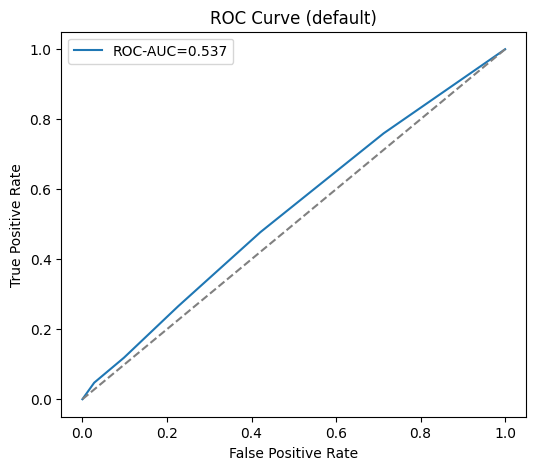

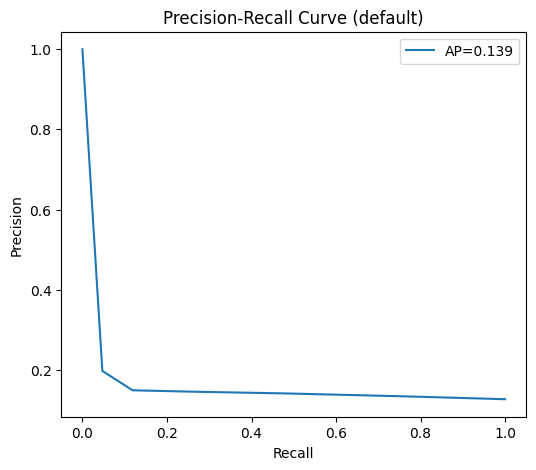

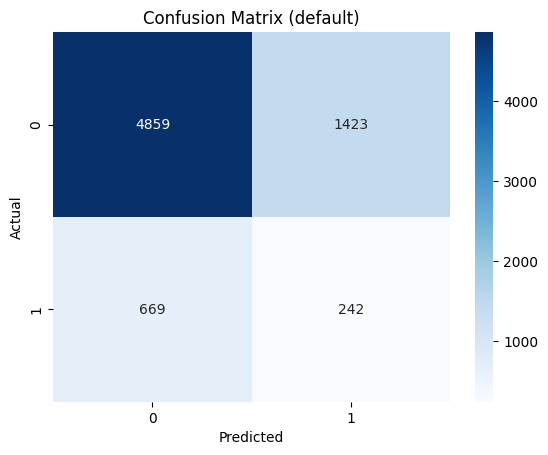

              precision    recall  f1-score   support

           0      0.879     0.773     0.823      6282
           1      0.145     0.266     0.188       911

    accuracy                          0.709      7193
   macro avg      0.512     0.520     0.505      7193
weighted avg      0.786     0.709     0.742      7193



NameError: name 'visualize_pca_feature_importance' is not defined

In [ ]:
results, best_model = model_pipeline_knn_pca(
    X_train_std, y_train,
    X_test_std, y_test,
    pca_method='default', use_smote=True
)
print(f"Test set → Acc={results['test_cv_accuracy']:.3f}, "
          f"F1={results['test_cv_f1']:.3f}, "
          f"ROC-AUC={results['test_cv_roc_auc']:.3f}, "
          f"AP={results['test_cv_ap']:.3f}")

# Visualize top features and PCs
loadings, corr_with_label = visualize_pca_feature_importance(
    best_model, X_train_smote_std, y_train_smote,
    top_n_features=10, top_n_pcs=5
)

In [14]:
print(f"Test set → Acc={results['cv_accuracy']:.3f}, "
          f"F1={results['cv_f1']:.3f}, "
          f"ROC-AUC={results['cv_roc_auc']:.3f}, "
          f"AP={results['cv_ap']:.3f}")


Test set → Acc=0.727, F1=0.267, ROC-AUC=0.570, AP=0.236


## Final performance on Test Set

                                                        PC1       PC2  \
occupation_type_Unemployed                         0.076896  0.000301   
name_family_status_Single / not married           -0.006722  0.003765   
occupation_type_Core staff                        -0.017429 -0.000287   
name_education_type_Secondary / secondary special  0.033412 -0.005808   
name_education_type_Higher education              -0.024384  0.003053   
name_income_type_Commercial associate             -0.026514  0.007879   
occupation_type_Managers                          -0.007943 -0.001883   
occupation_type_Sales staff                       -0.016742 -0.003015   
occupation_type_Laborers                          -0.022133  0.000992   
name_housing_type_With parents                    -0.014575  0.000221   

                                                        PC3       PC4  \
occupation_type_Unemployed                         0.016779 -0.131725   
name_family_status_Single / not married           

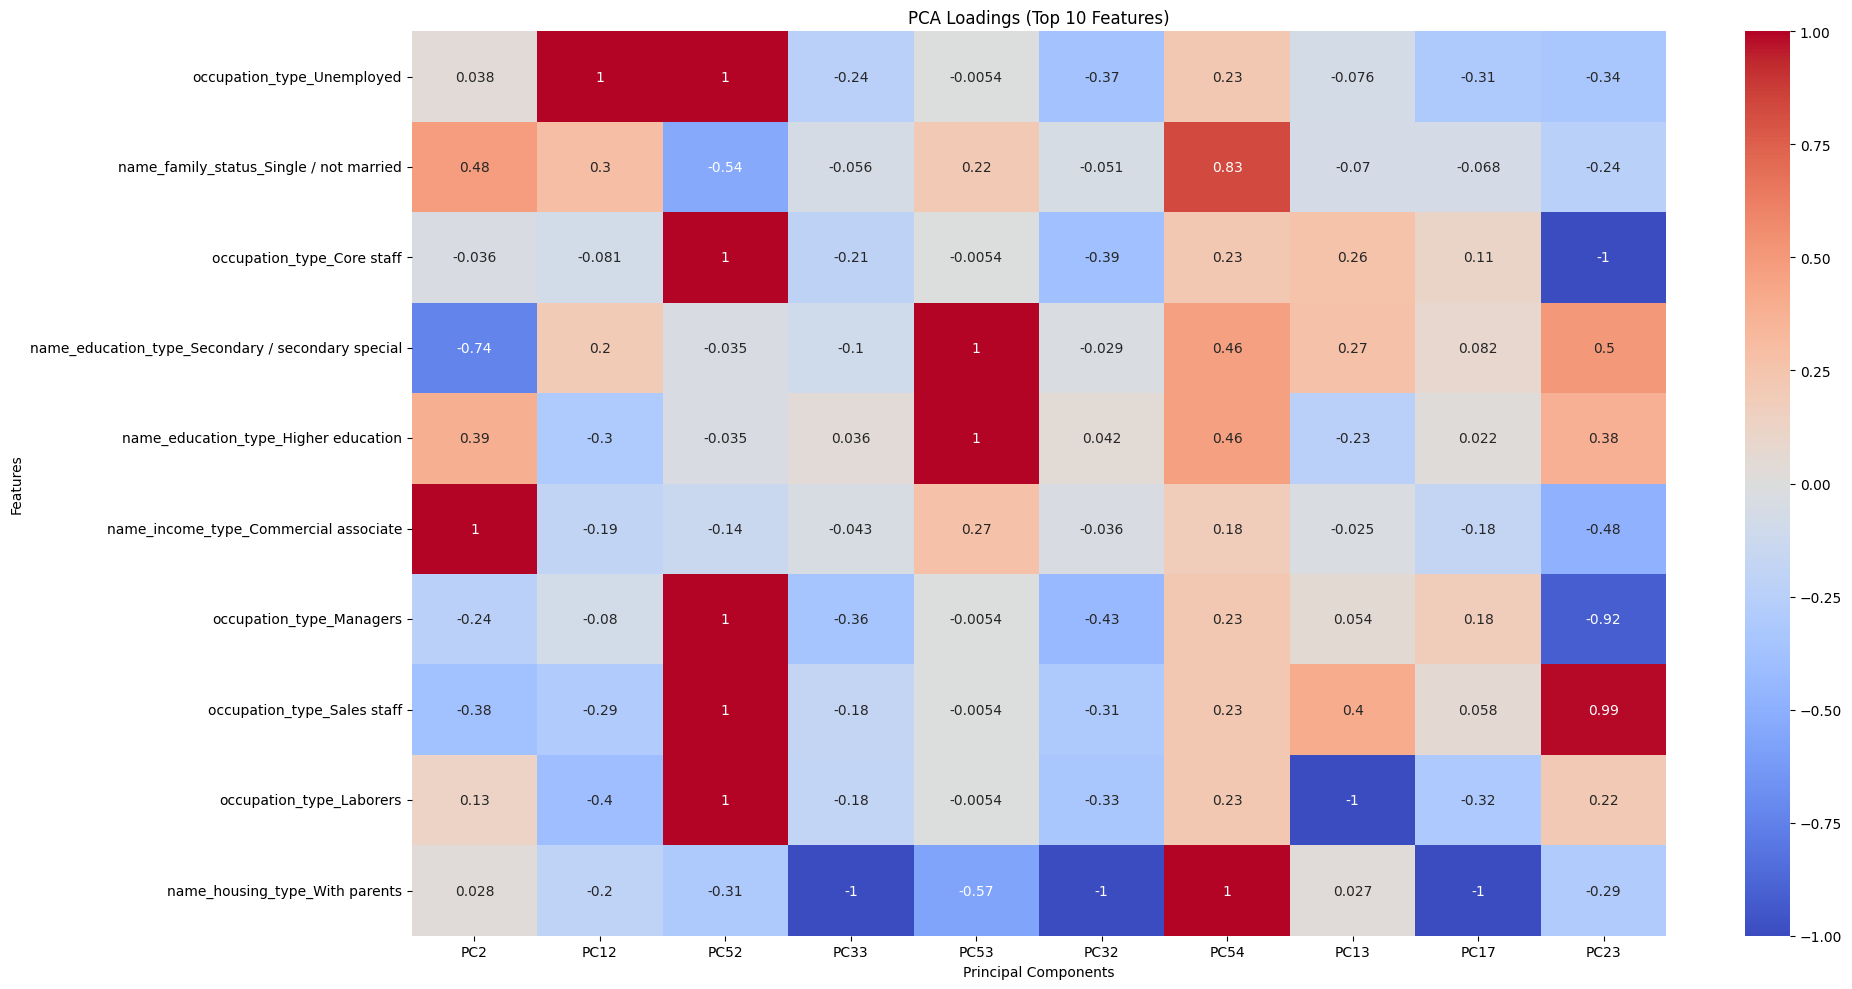

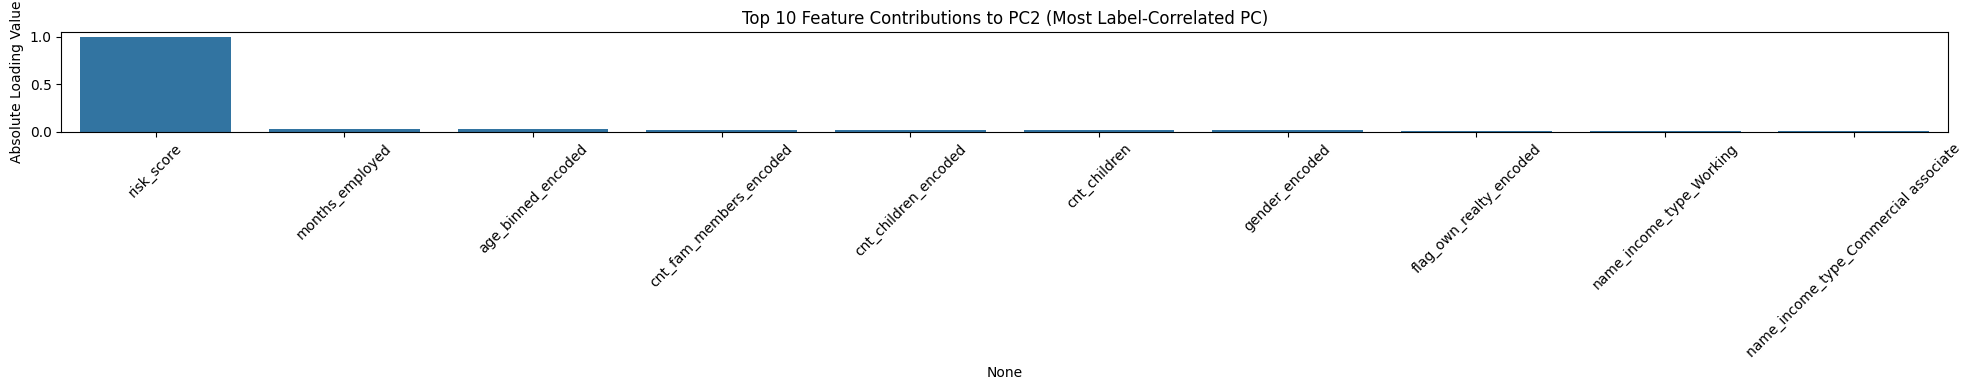

In [ ]:
pca_step = best_model.named_steps['pca (default)'] 


loadings = pd.DataFrame(pca_step.components_.T, 
                        index=X_train_smote_std.columns, 
                        columns=[f'PC{i+1}' for i in range(pca_step.n_components_)])

loadings['importance'] = np.sum(np.abs(loadings), axis=1)
loadings = loadings.sort_values('importance', ascending=False)
print(loadings.head(10))

X_pca = pca_step.transform(X_train_smote_std)

X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(pca_step.n_components_)])
X_pca_df['label'] = y_train_smote.values

corr_with_label = X_pca_df.drop(columns='label').corrwith(X_pca_df['label'])
corr_with_label = corr_with_label.abs().sort_values(ascending=False)

top_features = loadings.head(10).index
loadings_top_features = loadings.loc[top_features].drop(columns='importance')

top_features = loadings.head(10).index


top_pcs = corr_with_label.head(10).index  
loadings_top = loadings.loc[top_features, top_pcs]

# Then normalize loadings for visualization
loadings_scaled = loadings_top.apply(lambda x: x / np.max(np.abs(x)), axis=0)

# ---- Visualization: Heatmap ----
plt.figure(figsize=(20,10))
sns.heatmap(loadings_scaled, annot=True, cmap='coolwarm', center=0)
plt.title("PCA Loadings (Top 10 Features)")
plt.xlabel("Principal Components")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# ---- Visualization: PCs most correlated with label ----
top_pc = corr_with_label.idxmax()
plt.figure(figsize=(20,4))
sns.barplot(x=loadings[top_pc].abs().sort_values(ascending=False).head(10).index,
            y=loadings[top_pc].abs().sort_values(ascending=False).head(10).values)
plt.xticks(rotation=45)
plt.title(f"Top 10 Feature Contributions to {top_pc} (Most Label-Correlated PC)")
plt.ylabel("Absolute Loading Value")
plt.tight_layout()
plt.show()
